# Counterfactual plots and DAGs
#### Adapting from chapter 5 in 'Statistical Rethinking' (from R to Python)

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az

In [2]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/waffle_divorce.csv'), delimiter=";")
    data['MedianAgeMarriage_s'] = standardise(data['MedianAgeMarriage'])
    data['Marriage_s'] = standardise(data['Marriage'])
    data['Divorce_s'] = standardise(data['Divorce'])
    
    return data

In [3]:
d = data_proc()

In [4]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s,Marriage_s,Divorce_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.266989,-0.927058


#### Following the book the following DAG is specified. Age when married and the marriage rate both determine divorce, Age when married also determines the marriage rate.

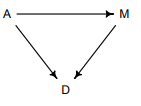

In [5]:
display(Image.open(os.path.join(os.getcwd(),r'data/dag.png')))

#### A recipe for generating plots of model predictions for the purposes of counterfactual analysis:
##### (1) Pick a variable to manipulate, the intervention variable.
##### (2) Define the range of values to set the intervention variable to.
##### (3) For each value of the intervention variable, and for each sample in posterior, use the causal model to simulate the values of other variables, including the outcome.

##### We build the following models:
$A -> D <- M$
$$ D_{i} \sim Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta_{m}M_{i} + \beta_{a}A_{i}$$
$$\alpha \sim Normal(0, 0.2)$$
$$\beta_{m} \sim Normal(0, 0.5)$$
$$\beta_{a} \sim Normal(0, 0.5)$$
$$\sigma \sim Exponential(1)$$ 

$A -> M$
$$ M_{i} \sim Normal(\mu_{m}, \sigma_{m})$$
$$\mu_{m} = \alpha_{m} + \beta_{am}A$$
$$\alpha_{m} \sim Normal(0, 0.2)$$
$$\beta_{am} \sim Normal(0, 0.5)$$
$$\sigma_{m} \sim Exponential(1)$$ 


In [6]:
with pm.Model() as model_1:
    a = pm.Normal('a', mu=0, sd=0.2)
    b = pm.Normal('b', mu=0, sd=0.5, shape=2)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b[0]*d.MedianAgeMarriage_s + b[1]*d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_1 = pm.sample(1000, tune=1000)

<ipython-input-6-1856de47b97e>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

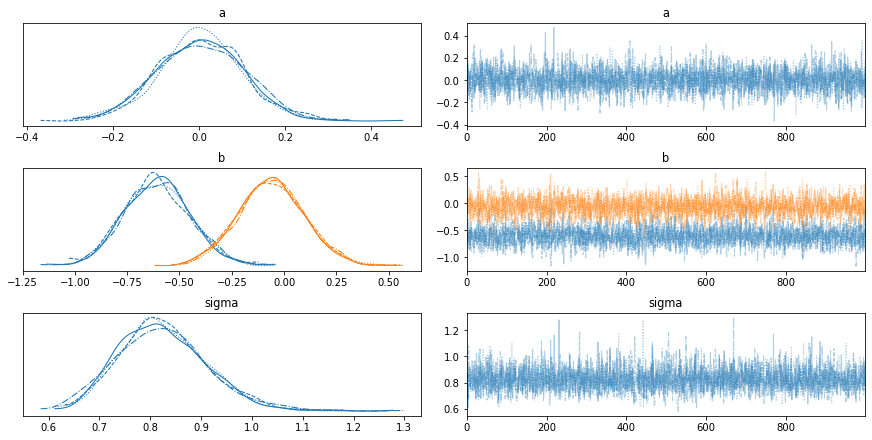

In [7]:
varnames=['a', 'b', 'sigma']
pm.plot_trace(trace_1, varnames)

##### Marriage rate has a neglible effect when controlling for marriage_age

In [8]:
pm.summary(trace_1, varnames)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.003,0.101,-0.189,0.190,0.002,0.001,3213.0,2990.0,1.0
b[0],-0.606,0.159,-0.902,-0.312,0.003,0.002,2379.0,2600.0,1.0
b[1],-0.060,0.160,-0.386,0.224,0.003,0.002,2580.0,2482.0,1.0
sigma,0.825,0.087,0.670,0.987,0.002,0.001,3139.0,2390.0,1.0


In [9]:
with pm.Model() as model_2:
    a = pm.Normal('a', mu=0, sd=0.2)
    b = pm.Normal('b', mu=0, sd=0.5, shape=1)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b[0]*d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_2 = pm.sample(1000, tune=1000)

<ipython-input-9-4e12ea8b9b15>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

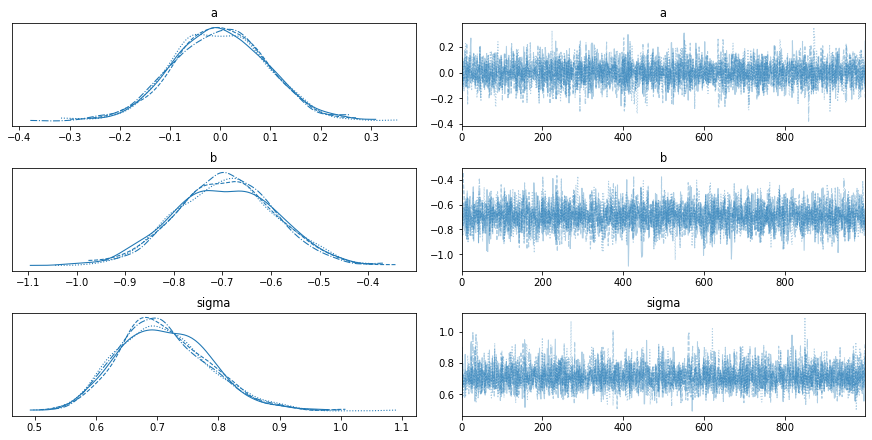

In [10]:
pm.plot_trace(trace_2, varnames)

In [11]:
pm.summary(trace_2, varnames)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.093,-0.173,0.166,0.001,0.001,4795.0,2920.0,1.0
b[0],-0.693,0.104,-0.879,-0.490,0.002,0.001,4379.0,2587.0,1.0
sigma,0.711,0.075,0.578,0.849,0.001,0.001,4960.0,2431.0,1.0


##### You’ll see that M and A are strongly negatively associated. If we interpret this causally, it indicates that manipulating A reduces M. The goal is to simulate what would happen, if we manipulate A. So next we define a range of values for A. I.e. 30 'imaginary' interventions ranging from 2 standard deviations below and above the mean.

In [12]:
#roll into one run
marriage_shared = shared(d["Marriage_s"].values)
age_shared = shared(d["MedianAgeMarriage_s"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=d["Divorce_s"])

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=d["Marriage_s"])

    m5_3_A_trace = pm.sample()
    

<ipython-input-12-90fbddcfe5e0>:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m5_3_A_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [13]:
a_seq = np.linspace(-2, 2, 50)

In [14]:
def get_ppc(variable, set_val, model, model_trace):
    variable.set_value(set_val)
    
    with model:
        model_ppc = pm.sample_posterior_predictive(model_trace)
    return model_ppc

In [15]:
m5_3_M_marriage = get_ppc(age_shared, a_seq, m5_3_A, m5_3_A_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


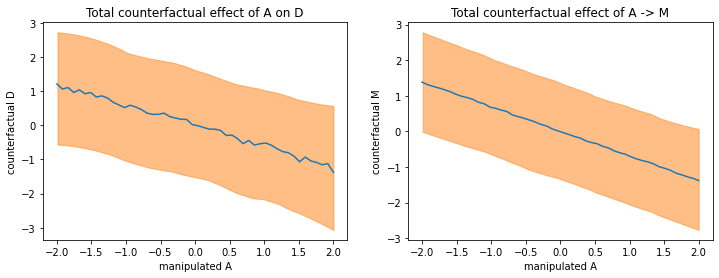

In [16]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(a_seq, m5_3_M_marriage["divorce"], ax=ax[0])
ax[0].plot(a_seq, m5_3_M_marriage["divorce"].mean(0))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(a_seq, m5_3_M_marriage["marriage"], ax=ax[1])
ax[1].plot(a_seq, m5_3_M_marriage["marriage"].mean(0))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

#### These plots visualize the predicted effect of manipulating age at marriage A on divorce rate D. Left: Total causal effect of manipulating A (horizontal) on D. The model allows some of the total causal effect of A to act through M, although the posterior distribution finds little support for an effect of M on D. This plot nevertheless contains both paths, A → D and A → M → D. Right: Simulated values of M show the estimated influence A → M.


In [17]:
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


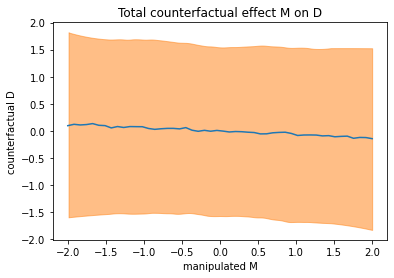

In [18]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc["divorce"], ax=ax)
ax.plot(marriage_counter_factual_x, m5_3_M_ppc["divorce"].mean(0))
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

##### The counterfactual effect of manipulating marriage rate M on divorce rate D. Since M → D was estimated to be very small, there is almost no trend here. By manipulat ing M, we break the influence of A on M, and this removes the association between M and D.

### Key Takeaway
##### When we manipulate some variable X, we break the causal influence of other variables on X. This is the same as saying we modify the DAG so that no arrows enter X. Suppose for example that we now simulate the effect of manipulating M. This implies the DAG the arrow A → M is deleted, because if we control the values of M, then A no longer influences it. It’s like a perfectly controlled experiment.

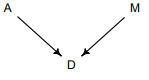

In [19]:
display(Image.open(os.path.join(os.getcwd(),r'data/dag2.png')))